In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sftc import config, utils

%load_ext autoreload
%autoreload 2

In [2]:
sns.set()

In [3]:
members, purchases = list(config.final.glob('*.csv'))
df_members = pd.read_csv(members, index_col=0)
df_purchases = pd.read_csv(purchases, index_col=0)

In [4]:
df_members

key      id                   created_at  \
0    mk8B0B9C4C3DD1B625   82365  Dec 30, 2018 @ 19:30:25.044   
1    mkF10D19889DAC6E62   82361  Dec 30, 2018 @ 15:00:30.785   
2    mkF8434FE514E9A668   82348  Dec 30, 2018 @ 00:09:18.849   
3    mkDDB162F9F4F223AF   82347  Dec 29, 2018 @ 23:50:49.381   
4    mk0C4A99B0BF073121   82340  Dec 29, 2018 @ 19:40:48.018   
..                  ...     ...                          ...   
768  mk1C166FBD69DE1352  135102   Oct 7, 2019 @ 10:01:16.537   
769  mk06AD44FF0F4755DA  135096   Oct 7, 2019 @ 07:23:18.633   
770  mkF074DE2CDFF49C13  135091   Oct 7, 2019 @ 05:15:13.635   
771  mk8194D80CE1707858  135090   Oct 7, 2019 @ 05:09:29.740   
772  mkB4898FFFF5D3B059  135088   Oct 7, 2019 @ 05:08:00.594   

     days_since_created_at  is_canadian  gender   yob  num_amazon_valid_trips  \
0                      372            1  Female  1954                       0   
1                      373            1     NaN    -1                       0   
2                      373            1     NaN    -1                       1   
3                      374            1    Male  1996                       6   
4                      373            1     NaN    -1                       2   
..                     ...          ...     ...   ...                     ...   
768                     92            1  Female  1961                       0   
769                     93            1  Female  1992                       0   
770                     93            1     NaN    -1                       0   
771                     93            1     NaN    -1                       0   
772                     93            1     NaN    -1                       0   

     days_since_last_purchase  total_spent  pg_crm  spend_type  bonus50  
0                         313        24.98       0           0        0  
1                        9999         0.00       0           0        0  
2                          66       634.56       0           0        0  
3                          80       147.05       0           1        1  
4                         345       200.57       0           0        0  
..                        ...          ...     ...         ...      ...  
768                      9999         0.00       1           0        0  
769                      9999         0.00       1           0        0  
770                      9999         0.00       1           0        0  
771                      9999         0.00       1           0        0  
772                      9999         0.00       1           0        0  

[11662 rows x 13 columns]

In [5]:
df_purchases.dtypes

country                    object
created_at                 object
gender                     object
id                         object
key                        object
postal_code                object
user_id                    object
yob                        object
days_since_created_at       int64
is_canadian                 int64
num_amazon_valid_trips      int64
referrals_made              int64
spent_shoppersdrugmart    float64
total_spent               float64
pg_crm                       bool
date                       object
advertiser                 object
cancelled_at               object
price (positive)           object
rate                      float64
extra.matched_asins        object
has_bonus                    bool
category_rate             float64
member_id                  object
price                      object
product_id                 object
asin                       object
brand                      object
product_group              object
pg_brand      

In [6]:
df_purchases['price'] = df_purchases['price'].apply(utils.convert_comma_to_float)

def strip_date(x):
    try:
        return x.split(' @ ')[0]
    except AttributeError:
        return x

df_purchases['date'] = pd.to_datetime((df_purchases['date']
                                       .apply(strip_date)), 
                                      format="%b %d, %Y")

## Exploratory vis

Comparing those who bought a product at 50% bonus vs. those who didn't during SFTC

In [24]:
keys = df_members.loc[df_members['bonus50'] == 1, 'key']
purchase_subset = df_purchases.query(' \
    key in @keys & \
    pg_brand == 1 & \
    date >= @config.START_DATE & date <= @config.END_DATE & \
    bonus50 == 0 \
    ') # Now looking only at purchases that weren't at 50%
display_data = (purchase_subset
                .groupby('key')
                .agg({
                    'actual_spent': 'sum',
                    'price': 'sum'
                }))

In [25]:
display_data

actual_spent  price
key                                    
033E966E44DE9352         23.2535  26.90
08C007A5B1C8D41E         68.8089  73.87
0A1C6ED4403BF1B0         23.5710  24.30
0AFD10AA76C673D8          8.6739   9.97
0C91A497AAE71A14         27.6741  28.53
...                          ...    ...
mkEDC06C40B08FFE3B       82.7724  89.97
mkF005B35B56E5F004       14.5209  14.97
mkF1E1EABA848FC87B       15.7819  16.27
mkF32950DA114E5834       36.2964  41.72
mkF8D35632B132B532       20.3603  20.99

[137 rows x 2 columns]

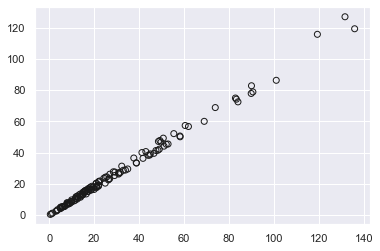

In [26]:
plt.scatter(display_data['price'], display_data['actual_spent'], color='none', edgecolor='k')

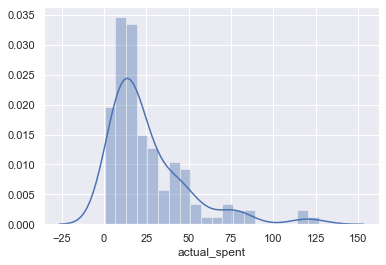

In [27]:
sns.distplot(display_data['actual_spent'], bins=20)

In [19]:
# Looking at not bonus50 people
keys = df_members.loc[df_members['bonus50'] == 0, 'key']
purchase_subset = df_purchases.query(' \
    key in @keys & \
    pg_brand == 1 & \
    date >= @config.START_DATE & date <= @config.END_DATE \
    ')
display_data = (purchase_subset
                .groupby('key')
                .agg({
                    'actual_spent': 'sum',
                    'price': 'sum'
                }))

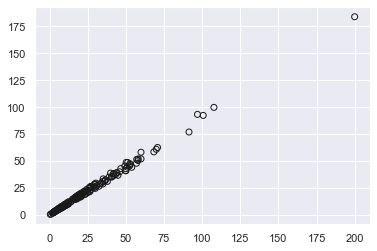

In [21]:
plt.scatter(display_data['price'], display_data['actual_spent'], color='none', edgecolor='k')

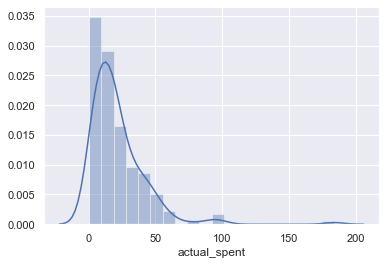

In [20]:
sns.distplot(display_data['actual_spent'], bins=20)

Comparing those who bought a product at 50% bonus vs. those who didn't participate in shop for the cure after SFTC

In [40]:
# Looking at not bonus50 people
keys50 = df_members.loc[df_members['bonus50'] == 0, 'key']
keysNoSftc = df_members.loc[df_members['spend_type'] != 1, 'key']

purchase_subset = df_purchases.query(' \
    pg_brand == 1 & \
    date >= @config.END_DATE \
    ')
purchases50 = (purchase_subset
               .query('key in @keys50')
               .groupby('key')
               .agg({'actual_spent': 'sum'}))

purchasesNoSftc = (purchase_subset
                   .query('key in @keysNoSftc')
                   .groupby('key')
                   .agg({'actual_spent': 'sum'}))


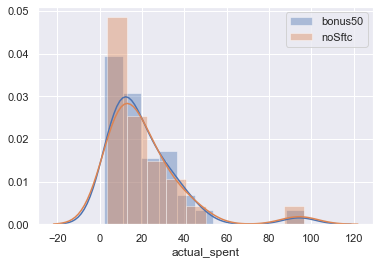

In [45]:
fig, ax = plt.subplots()
for data, lab in zip((purchases50, purchasesNoSftc), ('bonus50', 'noSftc')):
    sns.distplot(data['actual_spent'], ax=ax, label=lab)
plt.legend()
plt.show()